In [12]:
from keras.models import Sequential
#Import from keras_preprocessing not from keras.preprocessing
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, Rescaling
from keras.layers import Conv2D, MaxPooling2D, Conv3D
from keras.callbacks import ModelCheckpoint
from keras import regularizers, optimizers, Input
import pandas as pd
import numpy as np
from keras.optimizers import RMSprop, Adam
import ast
import random
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer
import os
import cv2
import re
from keras.applications import ResNet50
from tensorflow.keras.utils import Sequence
from keras.applications import VGG19
from tensorflow.keras.models import Model
from keras.saving import load_model
import pickle

In [32]:
X_train = np.load('./Datasets/X_train.npy')
X_val = np.load('./Datasets/X_val.npy')
y_train = np.load('./Datasets/y_train.npy')
y_val = np.load('./Datasets/y_val.npy')
with open('./Datasets/class_weights.pkl', 'rb') as file:
    loaded_class_weights = pickle.load(file)

In [4]:
IMG_SHAPE = X_train[0].shape

In [34]:
base_model = VGG19(include_top = False, weights = 'imagenet', input_shape = IMG_SHAPE)
base_model.trainable = False
model= Sequential()
model.add(Rescaling(1./255,input_shape = IMG_SHAPE))
model.add(base_model)
model.add(Flatten())
model.add(Dense(256,activation=('relu'))) 
model.add(Dropout(.2))
model.add(Dense(128,activation=('relu')))
model.add(Dropout(.2))
model.add(Dense(8,activation=('sigmoid')))

# Sanity check
print(f"\nModel input shape:\n{model.input_shape}\nModel output shape:\n"\
f"{model.output_shape}\n\n\nModel summary:") 
model.summary()


Model input shape:
(None, 224, 224, 3)
Model output shape:
(None, 8)


Model summary:
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_3 (Dense)             (None, 256)               6422784   
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 128)               32896     
                                 

In [35]:
# Model is saved at the end of every epoch, if it's the best seen so far.
checkpoint_filepath = './Checkpointnormalized'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [36]:
#Initializing the hyperparameters
batch_size= 2**6
initial_epochs=15
learn_rate=0.001
adam = Adam(learning_rate=learn_rate)

In [38]:
class CustomDataGenerator(Sequence):
    def __init__(self, X, y, batch_size, class_weights):
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.class_weights = class_weights

    def __len__(self):
        return int(np.ceil(len(self.X) / self.batch_size))

    def __getitem__(self, index):
        batch_X = self.X[index * self.batch_size:(index + 1) * self.batch_size]
        batch_y = self.y[index * self.batch_size:(index + 1) * self.batch_size]
        return batch_X, batch_y

    def on_epoch_end(self):
        # Optionally shuffle your data here
        pass

train_generator = CustomDataGenerator(X_train, y_train, batch_size, loaded_class_weights)

In [39]:

model.compile(optimizer=adam,loss='categorical_crossentropy',metrics=['accuracy'])

history = model.fit(train_generator,
                    epochs=initial_epochs,
                    validation_data=(X_val,y_val),
                    steps_per_epoch= len(X_train)/batch_size,
                    validation_steps=len(X_val),
                    callbacks=[model_checkpoint_callback],
                    verbose = 1)


Epoch 1/15
88/87 [==============================] - ETA: 0s - loss: 2.1081 - accuracy: 0.3629 INFO:tensorflow:Assets written to: ./Checkpointnormalized/assets


INFO:tensorflow:Assets written to: ./Checkpointnormalized/assets


87/87 [==============================] - 1573s 18s/step - loss: 2.1081 - accuracy: 0.3629 - val_loss: 1.8340 - val_accuracy: 0.2971
Epoch 2/15
88/87 [==============================] - ETA: 0s - loss: 2.1220 - accuracy: 0.3555 INFO:tensorflow:Assets written to: ./Checkpointnormalized/assets


INFO:tensorflow:Assets written to: ./Checkpointnormalized/assets


87/87 [==============================] - 1148s 13s/step - loss: 2.1220 - accuracy: 0.3555 - val_loss: 2.2958 - val_accuracy: 0.3983
Epoch 3/15
87/87 [==============================] - 1052s 12s/step - loss: 7.8668 - accuracy: 0.2778 - val_loss: 16.7813 - val_accuracy: 0.2758
Epoch 4/15
87/87 [==============================] - 1045s 12s/step - loss: 38.4528 - accuracy: 0.2688 - val_loss: 52.3698 - val_accuracy: 0.2758
Epoch 5/15
87/87 [==============================] - 1038s 12s/step - loss: 94.9075 - accuracy: 0.2691 - val_loss: 138.4785 - val_accuracy: 0.3983
Epoch 6/15
87/87 [==============================] - 1306s 15s/step - loss: 187.7588 - accuracy: 0.2697 - val_loss: 269.2062 - val_accuracy: 0.2758
Epoch 7/15
87/87 [==============================] - 1707s 19s/step - loss: 382.4538 - accuracy: 0.2828 - val_loss: 469.4022 - val_accuracy: 0.2758
Epoch 8/15
87/87 [==============================] - 1752s 20s/step - loss: 461.6650 - accuracy: 0.2665 - val_loss: 405.1428 - val_accuracy:

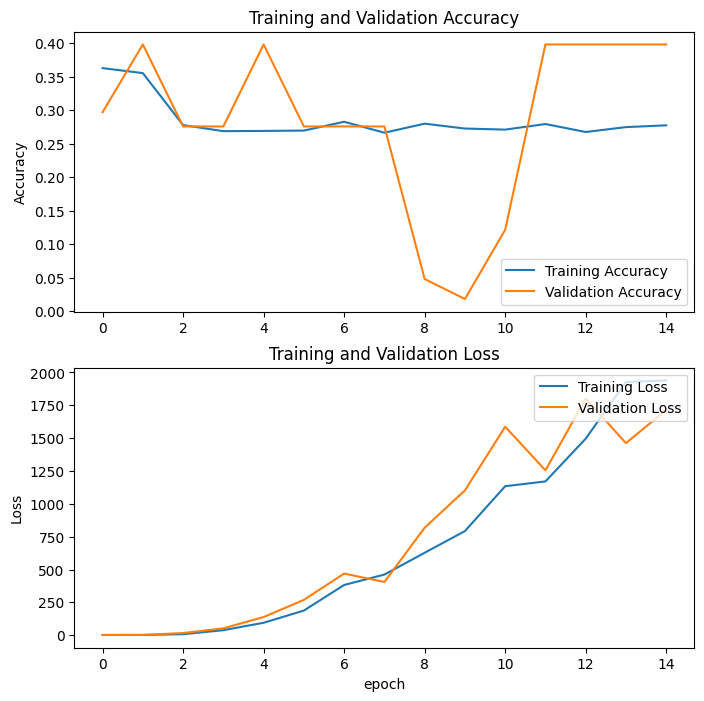

In [40]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
# plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Loss')
# plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# _ , accuracy = model.evaluate(x=X_test,y=y_test,batch_size= batch_size,verbose=1)
# print(f'Model accuracy on test set: {round(accuracy,3)*100}%')

In [41]:
testdfstart= pd.read_csv('XYZ_ODIR.csv')
testdfstart

,ID,N,D,G,C,A,H,M,O
0,937,0,0,0,0,0,0,0,0
1,967,0,0,0,0,0,0,0,0
2,988,0,0,0,0,0,0,0,0
3,995,0,0,0,0,0,0,0,0
4,1000,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
495,4787,0,0,0,0,0,0,0,0
496,4788,0,0,0,0,0,0,0,0
497,4789,0,0,0,0,0,0,0,0
498,4791,0,0,0,0,0,0,0,0


In [42]:
testdf = pd.DataFrame(np.repeat(testdfstart.values, 2, axis=0))
testdf.columns = testdfstart.columns

def append_extension(fn, side):
    return f"{fn}_{side}.jpg"

testdf['Side'] = testdf.index % 2

testdf['ID number'] = testdf.loc[:, 'ID']

testdf['ID number'] = testdf.apply(lambda row: append_extension(row['ID number'], 'left' if row['Side'] == 0 else 'right'), axis=1)

testdf.drop(columns=['Side'], inplace=True)

In [43]:
testdf = testdf[['ID', 'ID number', 'A', 'C', 'D', 'G', 'H', 'M', 'N', 'O']]

In [44]:
test_dir = './squared_and_cropped_dataset_test/'
test_img = [os.path.join(test_dir, i) for i in os.listdir(test_dir)]
img_size = 224

In [45]:
# Form the test labels
X_test = []
for image in tqdm(test_img):
    img = cv2.imread(image)
    # img = cv2.resize(img, (img_size, img_size), interpolation=cv2.INTER_CUBIC)
    # convert image to 2D to 3D
    # img = np.dstack([img, img, img])
    # convrt greyscale image to RGB
    # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # Normalalize Image
    img = img.astype(np.float32) / 255.
    X_test.append(img)

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:01<00:00, 573.08it/s]


In [46]:
X_test = np.asarray(X_test, dtype=np.float32)

In [47]:
model = load_model('./Checkpointnormalized/')
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_3 (Dense)             (None, 256)               6422784   
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 128)               32896     
                                                                 
 dropout_3 (Dropout)         (None, 128)              

In [48]:
batch_size=2**6
y_test = model.predict(X_test, steps=len(testdf)/batch_size)

15/15 [==============================] - 168s 11s/step


In [49]:
for i,j in enumerate(['A', 'C', 'D', 'G', 'H', 'M', 'N', 'O']):
  testdf[j]=y_test[:,i]

In [50]:
# Weer de columns omzetten naar de juiste class volgorde om het in te leveren
testdf = testdf[['ID', 'ID number', 'N' ,'D' ,'G', 'C', 'A' ,'H' ,'M', 'O']]

In [51]:
# For each two rows, take the max of the two rows
testdf = testdf.groupby(testdf.index // 2).max()

In [52]:
testdf = testdf.drop(columns=['ID number'])

In [53]:
testdf

,ID,N,D,G,C,A,H,M,O
0,937,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,967,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,988,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,995,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,1000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...
495,4787,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
496,4788,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
497,4789,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
498,4791,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [54]:
testdf.to_csv('submissionnormalized.csv', index=False)

# Finetuning the model